In [1]:
from exp.utils import *
from tqdm.notebook import tqdm
from multiprocessing import Pool

import torch
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
seed = 92
seed_everything(seed)

In [3]:
sigmoid = NN.Sigmoid()

In [4]:
model_name = "py_test_01"
bs = 16
epochs = 5
image_size = (228, 228)

In [5]:
device = get_device()

Using the GPU!


In [6]:
labels = get_labels()

In [7]:
train_df, valid_df, test_df = get_dataframes(small=False)

/home/favi/work/crx8/exp/utils.py:127: UserWarning: Train-Val-Split currently with patient overlap!
  warnings.warn("Train-Val-Split currently with patient overlap!")


In [8]:
train_label = train_df[labels].values
pos_weights = compute_positive_class_weigths(train_label)

In [9]:
train_tfs = transforms.Compose([
    transforms.Normalize([SUBSET_MEAN]*3, [SUBSET_STD]*3),
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.5)
])
test_tfs = transforms.Compose([
    transforms.Normalize([SUBSET_MEAN]*3, [SUBSET_STD]*3),
    transforms.Resize(image_size),
])

In [10]:
train_ds = CRX8_Data(train_df, get_image_path(), labels, transforms=train_tfs)
valid_ds = CRX8_Data(valid_df, get_image_path(), labels, transforms=test_tfs)
test_ds  = CRX8_Data(test_df , get_image_path(), labels, transforms=test_tfs)

In [11]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=bs, shuffle=False)

dataloaders = {
    "train": train_dl,
    "val": valid_dl,
    "test": test_dl
}

In [12]:
criterion = NN.BCEWithLogitsLoss(pos_weight=pos_weights.to(device), reduction="sum")

In [13]:
import torchvision.models as models
def pretrained_resnet34():
    model = models.resnet34(pretrained=True)
    model.fc = NN.Linear(512, len(labels))
    return model

def pretrained_densenet121():
    model = models.densenet121(pretrained=True)
    model.classifier = NN.Linear(1024, len(labels))
    return model

In [14]:
model = pretrained_densenet121()
model = model.to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

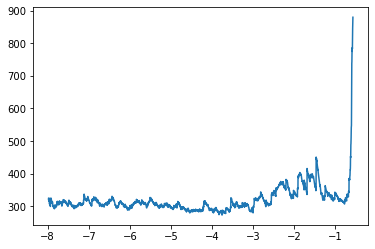

In [16]:
logs,losses = find_lr(model, train_dl, optimizer, criterion, device=device)
plt.plot(logs[10:-5],losses[10:-5])

In [17]:
lr = 1e-4

In [18]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [19]:
logger = Logger()
logger.add_metric("loss")
logger.add_metric("acc")
logger.add_metric("auroc")

In [20]:
num_steps = len(train_dl) * epochs
lr_range = (lr / 10, lr)
scheduler = OneCycleLR(optimizer, num_steps, lr_range)

In [ ]:
model = train_model(model, criterion, optimizer, scheduler, 
                    dataloaders, logger, model_name,
                    num_epochs=epochs, device=device)

In [ ]:
logger.plot_losses()

In [ ]:
logger.plot_acc()

In [ ]:
logger.plot_auroc()